<a href="https://colab.research.google.com/github/frankl1/Introduction-to-Tensorflow-for-Deep-Learning/blob/master/Cats_vs_Dogs_With_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
try:
  %tensorflow_version 2.x
except:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import logging

In [0]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Pre-trained model: MobileNet v2

In [0]:
pre_model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMG_RES = 224
model = tf.keras.models.Sequential([
  hub.KerasLayer(pre_model_url, input_shape=(IMG_RES, IMG_RES, 3))
])

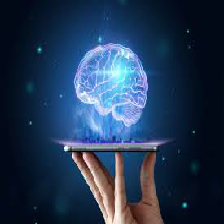

In [8]:
brain_url = tf.keras.utils.get_file("test-img1.jpg", "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTzxaVQILCXMtGZzY1KpkKQNInLOFand6RQn3wj2n9pAObrkDNU&s")
brain_img = Image.open(brain_url).resize((IMG_RES, IMG_RES))
brain_img

In [22]:
predictions = model.predict(brain_img[np.newaxis, ...])
predictions.shape

(1, 1001)

In [24]:
mobile_net_labels_path = tf.keras.utils.get_file("mobile_net_labels.txt", "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")
mobile_net_labels = np.array(open(mobile_net_labels_path).read().splitlines())
mobile_net_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

In [0]:
splits, infos = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True, split=tfds.Split.ALL.subsplit(weighted=[80, 20]))
train_examples, test_examples = splits
num_train_examples = infos.splits["train"].num_examples
num_classes = infos.features["label"].num_classes

In [43]:
# images do not have the same shape
for i, image in enumerate(train_examples.take(3)):
  print(i, image[0].shape)

0 (500, 343, 3)
1 (375, 500, 3)
2 (375, 500, 3)


In [0]:
def format(image, label):
  image = tf.image.resize(image, (IMG_RES, IMG_RES)) / 255
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_train_examples//4).map(format).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format).batch(BATCH_SIZE).prefetch(1)

# Imply the pre-trained model to cats vs dogs

In [58]:
images_batch, labels_batch = next(iter(train_batches.take(1)))
images_batch = images_batch.numpy()
labels_batch = labels_batch.numpy()
predictions = model.predict(images_batch)
prediction_labels = mobile_net_labels[np.argmax(predictions, axis=1)]
prediction_labels

array(['miniature pinscher', 'Egyptian cat', 'boxer', 'Egyptian cat',
       'breakwater', 'beagle', 'papillon', 'Yorkshire terrier', 'redbone',
       'tabby', 'Leonberg', 'Cardigan', 'American Staffordshire terrier',
       'tiger cat', 'paddle', 'dingo', 'Pembroke', 'vizsla', 'Great Dane',
       'Staffordshire bullterrier', 'Egyptian cat',
       'German short-haired pointer', 'cocker spaniel', 'Siberian husky',
       'hyena', 'Egyptian cat', 'comic book', 'tabby', 'muzzle',
       'Newfoundland', 'tabby', 'Siamese cat'], dtype='<U30')

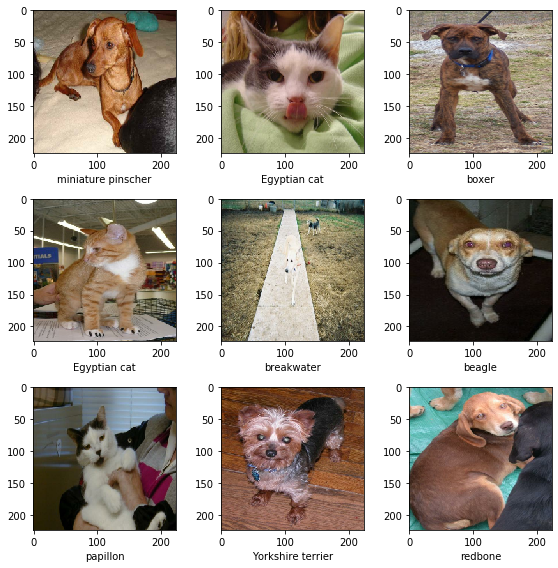

In [69]:
def plot_predictions(images, pred_labels):
  i = 1
  plt.figure(figsize=(8, 8))
  for img, pl in zip(images[:9], pred_labels[:9]):
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.xlabel(pl)
    i+=1
  plt.tight_layout()

plot_predictions(images_batch, prediction_labels)

# Simple transfer learning

In [83]:
mobile_net_feature_url="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(mobile_net_feature_url, input_shape=[IMG_RES, IMG_RES, 3])
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(2, activation="softmax")
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [90]:
EPOCH = 6
history = model.fit(train_batches, validation_data=test_batches, epochs=EPOCH)

Epoch 1/6
582/582 [==============================] - 43s 74ms/step - loss: 0.0159 - accuracy: 0.9948 - val_loss: 0.0354 - val_accuracy: 0.9877
Epoch 2/6
582/582 [==============================] - 45s 77ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.0326 - val_accuracy: 0.9894
Epoch 3/6
582/582 [==============================] - 45s 77ms/step - loss: 0.0129 - accuracy: 0.9961 - val_loss: 0.0349 - val_accuracy: 0.9886
Epoch 4/6
582/582 [==============================] - 43s 75ms/step - loss: 0.0116 - accuracy: 0.9967 - val_loss: 0.0433 - val_accuracy: 0.9873
Epoch 5/6
582/582 [==============================] - 45s 77ms/step - loss: 0.0115 - accuracy: 0.9966 - val_loss: 0.0366 - val_accuracy: 0.9873
Epoch 6/6
582/582 [==============================] - 44s 76ms/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0403 - val_accuracy: 0.9888


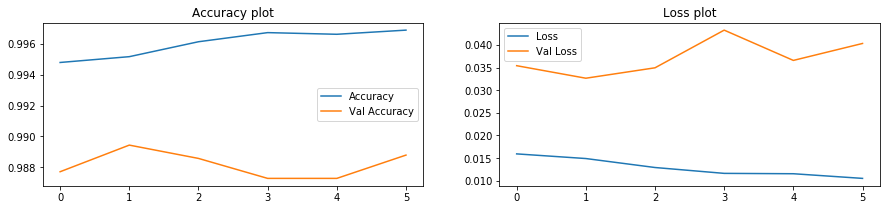

In [99]:
hist = history.history
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(hist["accuracy"], label="Accuracy")
plt.plot(hist["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy plot")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist["loss"], label="Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.title("Loss plot")
plt.legend()

In [116]:
class_names = infos.features["label"].names
class_names

['cat', 'dog']

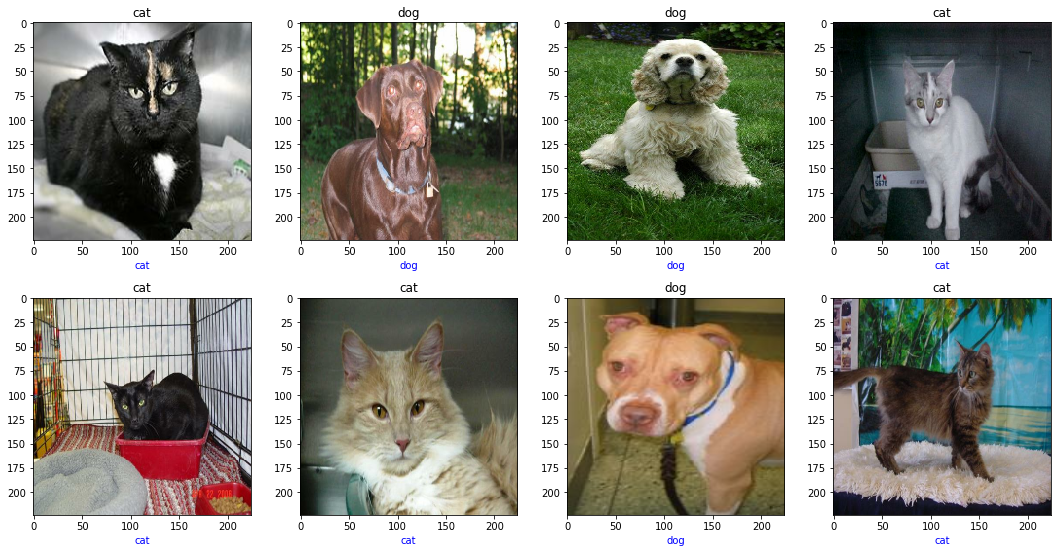

In [125]:
samples, labels = next(iter(test_batches.take(1)))
samples = samples.numpy()
labels = labels.numpy()
predictions = model.predict(samples)
predictions = np.argmax(predictions, axis=1)

plt.figure(figsize=(15, 15))
for i in range(8):
  c = "red" if predictions[i] != labels[i] else "blue"
  plt.subplot(4, 4, i+1)
  plt.imshow(samples[i])
  plt.xlabel(class_names[predictions[i]], color=c)
  plt.title(class_names[labels[i]])

plt.tight_layout()

In [120]:
labels[i]

<tf.Tensor: shape=(), dtype=int64, numpy=0>